# Kernel Methods and SVMs

First install and import needed packages and libraries

In [20]:
# !pip install numpy scipy pandas matplotlib scikit-learn missingno scikit-learn-extras

In [21]:
import numpy as np
import pandas as pd

We're going to use the [Iranian Churn Dataset](https://archive.ics.uci.edu/ml/datasets/Iranian+Churn+Dataset) from [Kaggle](https://www.kaggle.com/datasets/royjafari/customer-churn). 

The dataset was created with real world data of an Iranian telecom company. It provides an information about whether the company's client left them or not.

Such dataset can be used to help improving client's satisfaction and maximizing company's earnings.

The dataset contains information about costs of False Positive and False Negative classification for each client.

In [22]:
import matplotlib.pyplot as plt

churn_df = pd.read_csv("customer_churn_data.csv")
churn_df.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,131.2245,64.5805,0


In [23]:
y = churn_df.pop("Churn")
fn_cost = churn_df.pop("FN")
fp_cost = churn_df.pop("FP")

[Text(0.5, 0, 'Class'), Text(0, 0.5, 'Number of clients')]

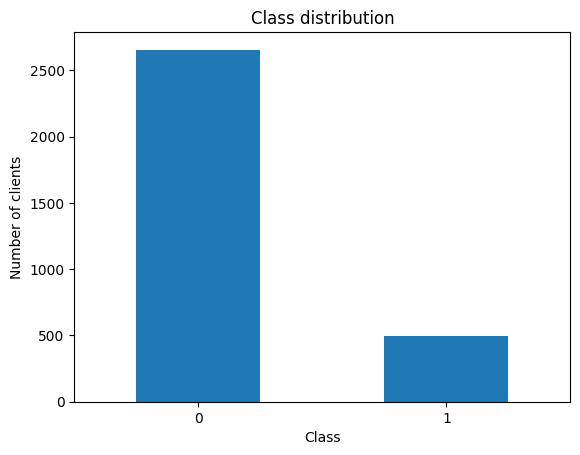

In [24]:
ax = y.value_counts()[[0, 1]].plot.bar(
    x="class", y="Number of clients", rot=0, title="Class distribution"
)
ax.set(xlabel="Class", ylabel="Number of clients")

Let's split and scale our data

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

(
    X_train,
    X_test,
    y_train,
    y_test,
    fp_cost_train,
    fp_cost_test,
    fn_cost_train,
    fn_cost_test,
) = train_test_split(
    churn_df, y, fp_cost, fn_cost, test_size=0.25, random_state=0, stratify=y
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Let's create a linear regression to use as our baseline for further comparison

In [26]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegressionCV

logreg_cv_l2 = LogisticRegressionCV(
    Cs=100, cv=5, scoring="f1", class_weight="balanced", random_state=0, n_jobs=-1
)
logreg_cv_l2.fit(X_train, y_train)

y_pred = logreg_cv_l2.predict(X_test)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

F1-score: 61.05%


Now let's train a linear SVM classifier and see how it compares with linear regression

Both baseline score and SVM score are not great. Let's see if we can improve the score with Kernel SVM

In [28]:
from sklearn.svm import SVC

clf_kernel_svc = SVC(cache_size=512, class_weight="balanced", random_state=0)
start_time = time()
clf_kernel_svc.fit(X_train, y_train)
end_time = time()
training_time = end_time - start_time

y_pred = clf_kernel_svc.predict(X_test)

print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")
print(f"Training time: {training_time} s")

F1-score: 65.71%
Training time: 0.02899932861328125 s


The improvement is noticeable but still not as great as we would like.

Maybe tuning the hyperparameters will help? We'll try a few different kernels

In [29]:
clf = SVC(cache_size=512, class_weight="balanced", random_state=0)

param_grid = [
    {
        "kernel": ["rbf"],
        "C": np.linspace(1e-2, 1e2, num=20),
        "gamma": ["scale"] + list(np.linspace(1e-1, 1e1, num=20)),
    },
    {
        "kernel": ["poly"],
        "C": np.linspace(1e-3, 1e3, 100),
        "degree": [2, 3, 4, 5],
    },
    {
        "kernel": ["sigmoid"],
        "C": np.linspace(1e-2, 1e2, num=20),
        "gamma": ["scale"] + list(np.linspace(1e-1, 1e1, num=20)),
    },
]


cv = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)

start_time = time()
cv.fit(X_train, y_train)
end_time = time()
training_time = end_time - start_time

y_pred = cv.predict(X_test)

print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")
print(f"Training time: {training_time} s")

F1-score: 87.02%
Training time: 30.119460105895996 s


In [27]:
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC

clf = LinearSVC(
    loss="hinge", max_iter=10000, random_state=0, class_weight="balanced", dual="auto"
)

param_grid = {"C": np.power(10.0, np.arange(-2, 2, 4 / 100))}

cv = GridSearchCV(estimator=clf, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1)

start_time = time()
cv.fit(X_train, y_train)
end_time = time()

prediction_time = end_time - start_time

print("prediction time: ", prediction_time, "s")
print("best C: ", cv.best_params_["C"])

y_pred = cv.predict(X_test)
print(f"F1-score: {100 * f1_score(y_test, y_pred):.2f}%")

training time:  2.2390427589416504 s
best C:  52.48074602497766
F1-score: 59.13%


The improvement is tremendous. Let's see what parameters enabled us to get this score

In [30]:
for param in cv.best_params_:
    print(f"best {param} : {cv.best_params_[param]}")

best C : 21.060526315789474
best gamma : 0.6210526315789474
best kernel : rbf


Now let's see the best validation score for each kernel!

In [31]:
results_df = pd.DataFrame(cv.cv_results_)

kernels = ["rbf", "poly", "sigmoid"]

for k in kernels:
    score = results_df.loc[results_df["param_kernel"] == k]["mean_test_score"].max()
    print(f"Best validation F1-score for {k} : {100 * score:.2f}%")
    print(results_df.loc[results_df["mean_test_score"] == score].get("params").iloc[0])
    print()

Best validation F1-score for rbf : 85.99%
{'C': 21.060526315789474, 'gamma': 0.6210526315789474, 'kernel': 'rbf'}

Best validation F1-score for poly : 85.51%
{'C': 1000.0, 'degree': 5, 'kernel': 'poly'}

Best validation F1-score for sigmoid : 63.44%
{'C': 0.01, 'gamma': 'scale', 'kernel': 'sigmoid'}


Okay. Let's try to train a model with these parameters and see the test score for each model 

In [32]:
for k in kernels:
    score = results_df.loc[results_df["param_kernel"] == k]["mean_test_score"].max()
    params = (
        results_df.loc[results_df["mean_test_score"] == score].get("params").iloc[0]
    )

    clf_kernel_svc = SVC(
        cache_size=512,
        class_weight="balanced",
        random_state=0,
        **params,
    )
    start_time = time()
    clf_kernel_svc.fit(X_train, y_train)
    end_time = time()
    training_time = end_time - start_time

    y_pred = clf_kernel_svc.predict(X_test)
    print(f"F1-score for {k} : {100 * f1_score(y_test, y_pred):.2f}%")
    print(f"Training time: {training_time} s")
    print()

F1-score for rbf : 87.02%
Training time: 0.038999319076538086 s
F1-score for poly : 87.22%
Training time: 0.1530005931854248 s
F1-score for sigmoid : 58.55%
Training time: 0.07500052452087402 s


During the validation, the rbf kernel performed the best. However, the testing shows that the polynomial kernel worked better

Let's save the best parameters for later

In [33]:
score = results_df.loc[results_df["param_kernel"] == "poly"]["mean_test_score"].max()
best_kernel_params = (
    results_df.loc[results_df["mean_test_score"] == score].get("params").iloc[0]
)



Now let's try to create a scoring function that will take into account the FN and FP values 

In [34]:
from typing import Union

from sklearn.metrics import make_scorer


def churn_cost(
    y_true: Union[np.ndarray, pd.Series],
    y_pred: Union[np.ndarray, pd.Series],
    fp_cost: Union[np.ndarray, pd.Series],
    fn_cost: Union[np.ndarray, pd.Series],
) -> float:
    # make sure all data is Numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    fp_cost = np.array(fp_cost)
    fn_cost = np.array(fn_cost)

    # check which rows are for FP and FN
    FP = (y_true == 0) & (y_pred == 1)
    FN = (y_true == 1) & (y_pred == 0)

    # get costs for FP and FN
    fp_real_cost = FP * fp_cost
    fn_real_cost = FN * fn_cost

    # return sum of costs
    return fp_real_cost.sum() + fn_real_cost.sum()


churn_cost_score = make_scorer(
    churn_cost,
    average="macro",
    greater_is_better=False,
)

now let's create two dummy classifiers. One that will always predict the positive class and one that always predicts negative

In [35]:
def DummyPredict(X, churn):
    return np.full(X.shape[0], churn)


y_pred_p = DummyPredict(X_test, 1)
y_pred_n = DummyPredict(X_test, 0)

print(
    f"F1-score for all positive predictions : {100 * f1_score(y_test, y_pred_p):.2f}%"
)
print(
    f"F1-score for all negative predictions : {100 * f1_score(y_test, y_pred_n):.2f}%"
)

print(
    f"Cost score for all positive predictions : {churn_cost(y_test, y_pred_p, fp_cost_test, fn_cost_test):.2f}"
)
print(
    f"Cost score for all negative predictions : {churn_cost(y_test, y_pred_n, fp_cost_test, fn_cost_test):.2f}"
)

F1-score for all positive predictions : 27.19%
F1-score for all negative predictions : 0.00%
Cost score for all positive predictions : 69593.20
Cost score for all negative predictions : 15871.64


We can see that unfortunately the cost of letting all unsatisfied clients go is much lower than the cost of trying to assume that all clients might leave

How can SVM help us lower that cost?

In [36]:
lin_clf = LinearSVC(
    loss="hinge",
    max_iter=10000,
    random_state=0,
    class_weight="balanced",
    C=52.48074602497766,
    dual="auto",
)
lin_clf.fit(X_train, y_train)
y_pred = lin_clf.predict(X_test)
print(f"churn cost: {churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test):.2f}")


clf_kernel_svc = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0,
    **best_kernel_params,
)
clf_kernel_svc.fit(X_train, y_train)
y_pred = clf_kernel_svc.predict(X_test)
print(f"F1-score  : {100 * f1_score(y_test, y_pred):.2f}%")
print(f"churn cost: {churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test):.2f}")

churn cost: 11629.98
F1-score  : 87.22%
churn cost: 3700.22


We can lower the cost over 4 times! This means very large fund savings especially for companies that operate on a very large scale

## Kernel approximation - TODO

When using kernel SVM is too computationally expensive we can use group kernel approximation algorithm to approximate the kernel features.

`Nyström` method is a universal algorithm that can approximate any kernel. It approximates the matrix using truncated SVD.
We're also going to use scikit-learn's `RBGSampler` and `Fastfood` samplers

In [37]:
lin_svm = LinearSVC(
    loss="hinge", max_iter=10000, random_state=0, class_weight="balanced", dual="auto"
)

kernel_svm = SVC(
    cache_size=512,
    class_weight="balanced",
    random_state=0,
    kernel="rbf",
)

start_time = time()
lin_svm.fit(X_train, y_train)
end_time = time()
y_pred = lin_svm.predict(X_test)
print("linear svm")
print(f"Training time: {end_time - start_time} s")
print(f"F1-score     : {100 * f1_score(y_test, y_pred):.2f}%")
print(f"churn cost   : {churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test):.2f}")
print()

start_time = time()
kernel_svm.fit(X_train, y_train)
end_time = time()
y_pred = kernel_svm.predict(X_test)
print("kernel svm")
print(f"Training time: {end_time - start_time} s")
print(f"F1-score     : {100 * f1_score(y_test, y_pred):.2f}%")
print(f"churn cost   : {churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test):.2f}")
print()

linear svm
Training time: 0.013000965118408203 s
F1-score     : 59.13%
churn cost   : 11629.98

kernel svm
Training time: 0.028000354766845703 s
F1-score     : 65.71%
churn cost   : 9129.26


In [38]:
from sklearn_extra.kernel_approximation import Fastfood
from sklearn.kernel_approximation import RBFSampler, Nystroem
from sklearn.pipeline import Pipeline

pipe_rbfs = Pipeline(
    [
        ("rbfs", RBFSampler()),
        (
            "svm",
            LinearSVC(
                loss="hinge",
                max_iter=10000,
                random_state=0,
                class_weight="balanced",
                dual="auto",
            ),
        ),
    ]
)

pipe_fastfood = Pipeline(
    [
        ("fastfood", Fastfood()),
        (
            "svm",
            LinearSVC(
                loss="hinge",
                max_iter=10000,
                random_state=0,
                class_weight="balanced",
                dual="auto",
            ),
        ),
    ]
)

pipe_nystroem = Pipeline(
    [
        ("rbfs", Nystroem()),
        (
            "svm",
            LinearSVC(
                loss="hinge",
                max_iter=10000,
                random_state=0,
                class_weight="balanced",
                dual="auto",
            ),
        ),
    ]
)

pipes = [pipe_rbfs, pipe_fastfood, pipe_nystroem]
names = ["rbfs", "fastfood", "nystroem"]

In [39]:
for pipe, name in zip(pipes, names):
    start_time = time()
    pipe.fit(X_train, y_train)
    end_time = time()
    y_pred = pipe.predict(X_test)
    print(name)
    print(f"Training time: {end_time - start_time} s")
    print(f"F1-score     : {100 * f1_score(y_test, y_pred):.2f}%")
    print(
        f"churn cost   : {churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test):.2f}"
    )
    print()

rbfs
Training time: 0.026999473571777344 s
F1-score     : 61.72%
churn cost   : 12669.76
fastfood
Training time: 0.13000249862670898 s
F1-score     : 69.68%
churn cost   : 10265.32

nystroem
Training time: 0.028999805450439453 s
F1-score     : 64.94%
churn cost   : 10137.79


Let's tune hyperparameters - C, gamma and n_components - for one of the pipelines

In [40]:
pipe_nystroem = Pipeline(
    [
        ("nystroem", Nystroem()),
        (
            "svm",
            LinearSVC(
                loss="hinge",
                max_iter=10000,
                random_state=0,
                class_weight="balanced",
                dual="auto",
            ),
        ),
    ]
)

param_grid = {
    "svm__C": np.linspace(1e-3, 1e3, 10),
    "nystroem__gamma": list(np.linspace(1e-2, 1, num=20)),
    "nystroem__n_components": np.arange(80, 130, 10),
}
cv = GridSearchCV(
    estimator=pipe_nystroem, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1
)

start_time = time()
cv.fit(X_train, y_train)
end_time = time()
y_pred = cv.predict(X_test)
print(f"Training time: {end_time - start_time} s")
print(f"F1-score     : {100 * f1_score(y_test, y_pred):.2f}%")
print(f"churn cost   : {churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test):.2f}")
print(cv.best_params_)

Training time: 73.4363865852356 s
F1-score     : 80.00%
churn cost   : 4798.14
{'nystroem__gamma': 0.06210526315789474, 'nystroem__n_components': 120, 'svm__C': 111.11200000000001}


C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [41]:
pipe_fastfood = Pipeline(
    [
        ("fastfood", Fastfood()),
        (
            "svm",
            LinearSVC(
                loss="hinge",
                max_iter=10000,
                random_state=0,
                class_weight="balanced",
                dual="auto",
            ),
        ),
    ]
)

param_grid = {
    "svm__C": np.linspace(1e-3, 1e3, 10),
    "fastfood__sigma": np.linspace(0.5, 1.5, 7) * np.sqrt(1 / 2),
    "fastfood__n_components": np.arange(80, 130, 10),
}
cv = GridSearchCV(
    estimator=pipe_fastfood, param_grid=param_grid, scoring="f1", cv=5, n_jobs=-1
)

start_time = time()
cv.fit(X_train, y_train)
end_time = time()
y_pred = cv.predict(X_test)
print(f"Training time: {end_time - start_time} s")
print(f"F1-score     : {100 * f1_score(y_test, y_pred):.2f}%")
print(f"churn cost   : {churn_cost(y_test, y_pred, fp_cost_test, fn_cost_test):.2f}")
print(cv.best_params_)

Training time: 194.35895442962646 s
F1-score     : 79.26%
churn cost   : 6052.96
{'fastfood__n_components': 120, 'fastfood__sigma': 1.0606601717798214, 'svm__C': 111.11200000000001}


C:\Users\piotr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


We're not getting closer to the scores achieved using kernel svm but the results are much better than those of simple linear svm